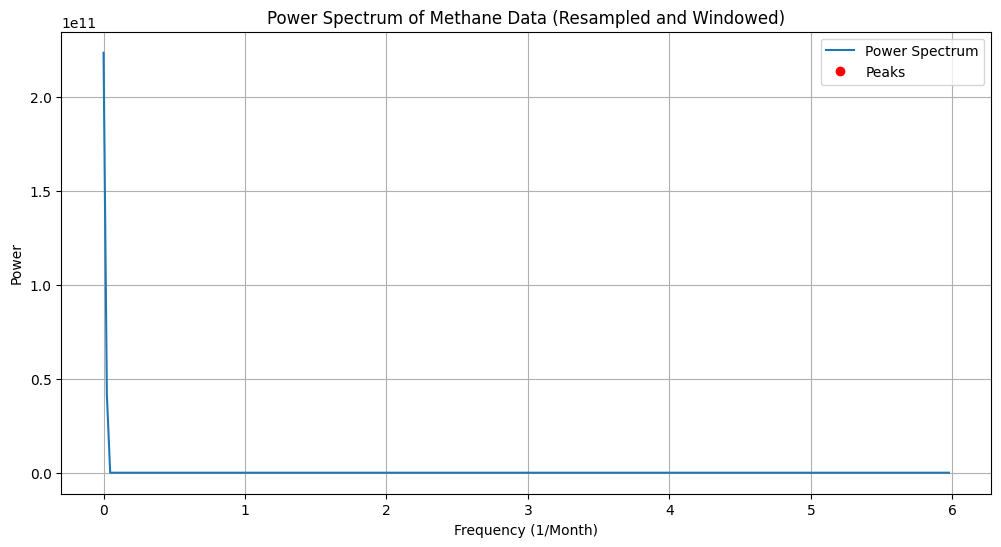

In [21]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, windows
import pandas as pd
import numpy as np

def fft_mag(data):
    """
    This function computes the FFT of the input data without 
    enforcing strict timestamp checks.
    
    Parameters:
    - data: Pandas Series, with values representing the time series data.

    Returns:
    - The FFT result of the data.
    """
    return np.fft.fft(data.values)

# Load and preprocess the methane data
def get_timeseries(path):
    data = pd.read_json(path, lines=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)

    # Remove duplicate timestamps
    data = data[~data.index.duplicated(keep='first')]

    # Resample to monthly frequency and fill any remaining gaps
    data = data.resample('MS').ffill().bfill()
    return data['value']

file_path = 'methane-data-collection/data/methane_data.json'
methane_data = get_timeseries(file_path)

# Apply windowing
n = len(methane_data)
window = windows.hamming(n)
windowed_data = methane_data * window

# Perform FFT
fft_result = fft_mag(windowed_data)

# Zero-padding for frequency resolution
n_padded = 2 ** int(np.ceil(np.log2(len(fft_result))))
padded_fft_result = np.pad(fft_result, (0, n_padded - len(fft_result)), 'constant')

# Frequency calculation (assuming monthly data)
freqs = np.fft.fftfreq(n_padded, d=1/12)  # Monthly frequency

# Noise reduction using thresholding
magnitude = np.abs(padded_fft_result)
threshold = magnitude.mean() * 1.5
fft_clean = padded_fft_result.copy()
fft_clean[magnitude < threshold] = 0

# Inverse FFT for cleaned data
cleaned_data = np.fft.ifft(fft_clean).real[:n] / window  # Only keep original length

# Power spectrum calculation
power_spectrum = np.abs(fft_clean[:len(fft_clean) // 2]) ** 2
freqs = freqs[:len(power_spectrum)]  # Limit to positive frequencies

# Identify peaks in the power spectrum
peaks, _ = find_peaks(power_spectrum, height=power_spectrum.max() * 0.1)

# Plot the power spectrum and highlight peaks
plt.figure(figsize=(12, 6))
plt.plot(freqs, power_spectrum, label='Power Spectrum')
plt.plot(freqs[peaks], power_spectrum[peaks], 'ro', label='Peaks')
plt.title('Power Spectrum of Methane Data (Resampled and Windowed)')
plt.xlabel('Frequency (1/Month)')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()
